# Avazu CTR广告点击率预测（lightGBM）

* Content：对Netflix数据集进行评分预测
* Author:  HuiHui
* Date:    2020-06-01
* Reference:https://www.kaggle.com/c/avazu-ctr-prediction

## 提交说明

* 说明采用的模型，LogLoss值
* 提交结果，评分截图

## Avazu数据集

* **训练集：**10天的点击数据，按时间顺序排列。根据不同的策略对非点击和点击进行二次采样。
* **测试集：** 1天的广告用于测试模型   
* **提交文件：**
* **字段：**  
&emsp;**click:** 0-不点击，1-点击   
&emsp;**C1，C14-C21：**匿名分类变量  
&emsp;**hour:** 格式为YYMMDDHH

## 导入相关库

In [1]:
# !/usr/bin/env python
# -*- coding=utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import LabelEncoder
from dummyPy import OneHotEncoder
import random
import pickle  # 存储临时变量
from tqdm import tqdm
import gc

from sklearn.linear_model import SGDClassifier  # 梯度下降分类
from sklearn.metrics import log_loss
import lightgbm as lgb
from sklearn.model_selection import train_test_split

## 数据预处理

* 特征选择  
* 绘制分类数据分布图
* 将所有不常用的分类转换成'other'
* LabelEncoder、OneHotEncoder
* 下采样训练样本

loading data...


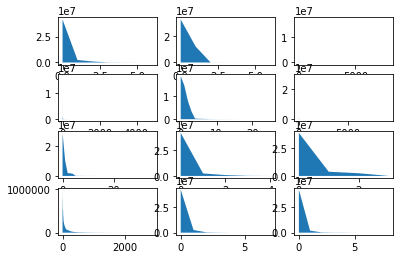

In [2]:
## 读文件
# file_path = '/Users/wangdonghui/Desktop/ZGZ/RS/dataset/avazu-ctr-prediction/' # mac路径
file_path = 'C:/Users/Administrator/Desktop/W/DataSet/avazu/' # win路径
fp_train = file_path + 'train.csv'
fp_test  = file_path + 'test.csv'

## 下采样写文件
fp_sub_train_f = file_path + 'sub_train_f.csv'
fp_col_counts = file_path + 'col_counts'

## data after selecting features (LR_fun needed)
## and setting rare categories' value to 'other' (feature filtering)
fp_train_f = file_path + 'train_f.csv'
fp_test_f  = file_path + 'test_f.csv'

## 存储标签编码和one-hot编码
fp_lb_enc = file_path + 'lb_enc'
fp_oh_enc = file_path + 'oh_enc'

##==================== 数据预处理 ====================##
# 特征选择
cols = ['C1', 
        'banner_pos', 
        'site_domain', 
        'site_id',
        'site_category',
        'app_id',
        'app_category', 
        'device_type', 
        'device_conn_type',
        'C14', 
        'C15',
        'C16']

cols_train = ['id', 'click']
cols_test  = ['id']
cols_train.extend(cols)
cols_test.extend(cols)

## 数据加载
print('loading data...')
df_train_ini = pd.read_csv(fp_train, nrows = 10)# nrows = 10读取一个大文件中的几行数据
df_train_org = pd.read_csv(fp_train, chunksize = 10000000, iterator = True)# 分块读取,iterator = True返回一个可迭代对象TextFileReader,reader.get_chunk(5)返回前五条数据
df_test_org  = pd.read_csv(fp_test,  chunksize = 10000000, iterator = True)

# print(df_train_ini.head())
# print("=="*50)
# print(df_train_org.get_chunk(5))
# print("=="*50)
# print(df_test_org.get_chunk(5))

#----- 统计分类变量 数值个数 -----#
## 初始化
cols_counts = {}  # 统计每个特征的分类数量
for col in cols:
    cols_counts[col] = df_train_ini[col].value_counts()

## 统计训练集
for chunk in df_train_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())   

## 统计测试集
for chunk in df_test_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())

## 统计      ??? 多统计了一次df_train_ini的特征
for col in cols:
    cols_counts[col] = cols_counts[col].groupby(cols_counts[col].index).sum()
    # sort the counts
    cols_counts[col] = cols_counts[col].sort_values(ascending=False)   

## 存储value_counting
pickle.dump(cols_counts, open(fp_col_counts, 'wb'))

## 绘制分布
fig = plt.figure(1)
for i, col in enumerate(cols):
    ax = fig.add_subplot(4, 3, i+1)
    ax.fill_between(np.arange(len(cols_counts[col])), cols_counts[col].get_values())
    # ax.set_title(col)
plt.show()

In [3]:
## 只保存前K个分类变量
k = 99
col_index = {}
for col in cols:
    col_index[col] = cols_counts[col][0: k].index

df_train_org = pd.read_csv(fp_train, dtype = {'id': str}, chunksize = 10000000, iterator = True)
df_test_org  = pd.read_csv(fp_test,  dtype = {'id': str}, chunksize = 10000000, iterator = True)

## 训练集
hd_flag = True  # add column names at 1-st row
for chunk in df_train_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # 将所有稀有的分类转换成'other'
        df.loc[~df[col].isin(col_index[col]), col] = 'other'    ####？？？？？？
    with open(fp_train_f, 'a') as f:
        df.to_csv(f, columns = cols_train, header = hd_flag, index = False)
    hd_flag = False

## 测试集
hd_flag = True  # 第一个chunk需要有header
for chunk in df_test_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # 设置其他不常用变量为other
        df.loc[~df[col].isin(col_index[col]), col] = 'other'
    with open(fp_test_f, 'a') as f:
        df.to_csv(f, columns = cols_test, header = hd_flag, index = False)      
    hd_flag = False    

print("ok")

ok


In [4]:
## 对分类变量进行标签编码
lb_enc = {}
for col in cols:
    col_index[col] = np.append(col_index[col], 'other')

for col in cols:
    lb_enc[col] = LabelEncoder()
    lb_enc[col].fit(col_index[col])
    
## 存储标签编码
pickle.dump(lb_enc, open(fp_lb_enc, 'wb'))

## one-hot编码
oh_enc = OneHotEncoder(cols)

df_train_f = pd.read_csv(fp_train_f, index_col=None, chunksize=5000000, iterator=True)
df_test_f  = pd.read_csv(fp_test_f, index_col=None, chunksize=5000000, iterator=True)

for chunk in df_train_f:
    oh_enc.fit(chunk)
for chunk in df_test_f:
    oh_enc.fit(chunk)
    
## 存储one-hot编码
pickle.dump(oh_enc, open(fp_oh_enc, 'wb'))

print("ok")

ok


In [ ]:
# 计算总训练样本 约46M
n = sum(1 for line in open(fp_train_f)) - 1 
# 保存下采样训练样本 2M
s = 2000000

## 设置哪些行不需要读 skip，不需要读的行数为n-s
skip = sorted(random.sample(range(1, n+1), n-s)) 
df_train = pd.read_csv(fp_train_f, skiprows = skip)
df_train.columns = cols_train

## 存储下采样的结果
df_train.to_csv(fp_sub_train_f, index=False) 

print("ok")

## CTR预测（LR）

training...
training...
LR model saved
[0.5902272122294253, 0.5590883409976604]


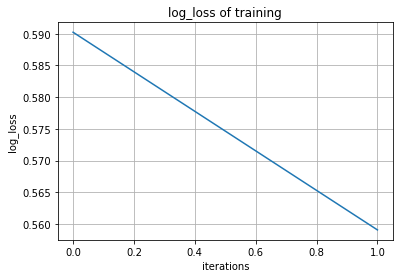

predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predic

In [9]:
##==================== 设置文件路径File-Path (fp) ====================##
file_path = '/Users/wangdonghui/Desktop/ZGZ/RS/dataset/avazu-ctr-prediction/' # mac路径
# file_path = 'C:/Users/Administrator/Desktop/W/DataSet/avazu/' # win路径

# 全量样本
fp_train_f = file_path + "train_f.csv"
# 小样本
fp_sub_train_f = file_path + 'sub_train_f.csv'

fp_test_f  = file_path + "test_f.csv"

# one-hot编码保存
fp_oh_enc = file_path + "oh_enc"
# LR模型保存
fp_lr_model = file_path + "lr/lr_model"
# submission文件保存
fp_sub = file_path + "lr/LR_submission.csv"

##==================== LR模型 训练 ====================##
oh_enc = pickle.load(open(fp_oh_enc, 'rb'))

# 一个chunk块为5万行
chunksize = 50000
# df_train_f = pd.read_csv(fp_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取全量样本
df_train_f = pd.read_csv(fp_sub_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取小样本
# print(df_train_f.get_chunk(5))

# 使用LogLoss作为LR的损失函数
lr_model = SGDClassifier(loss='log')  
scores = []

# 使用k和i调整训练规模，训练样本 = 所有样本 / k
k = 20 #100  
i = 1
for chunk in df_train_f:
    # 根据K drop掉样本
    if i < k: 
        i += 1
        continue
    print('training...')
    i = 1
    df_train = oh_enc.transform(chunk)
    # LR训练
    feature_train = df_train.columns.drop(['id', 'click'])
    train_X = df_train[feature_train]
    train_y = df_train['click'].astype('int')
    lr_model.partial_fit(train_X, train_y, classes = [0,1])  # fitting
    
    # 训练结果logloss分数
    y_pred = lr_model.predict_proba(train_X)[:, 1]
    score = log_loss(train_y, y_pred)
    scores.append(score)

## 存储训练好的LR模型
pickle.dump(lr_model, open(fp_lr_model, 'wb'))
print('LR model saved')

print(scores)
#scores = [0.1, 0.2, 0.3, 0.4]
## 绘制LR训练分数曲线
#f1 = plt.figure(1)
plt.title("LR Training Curve") 
plt.plot(scores)
plt.xlabel('iterations')
plt.ylabel('log_loss')
plt.title('log_loss of training')
plt.grid()
plt.show()

import gc
del lr_model
del df_train_f
gc.collect()

##==================== 使用训练好的LR模型进行预测，提交submission ====================##
df_test_f = pd.read_csv(fp_test_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True)        
lr_model = pickle.load(open(fp_lr_model, 'rb'))

# 按照chunk对测试集进行预测
header = True
for chunk in df_test_f:
    print('predicting...')
    df_test = oh_enc.transform(chunk)
    # 去掉ID字段
    feature_test = df_test.columns.drop(['id'])
    test_X = df_test[feature_test]
    # 计算class=1的概率
    y_pred = lr_model.predict_proba(test_X)[:, 1]  
    # 得到submittion
    chunk['click'] = y_pred
    with open(fp_sub, 'a') as f: 
        # 只有第一次header=True，其余header=False
        chunk.to_csv(f, columns=['id', 'click'], header=header, index=False) 
    header = False

print('submittion completed')

## CTR预测（lightGBM）

In [10]:
##==================== 设置文件路径File-Path (fp) ====================##
file_path = '/Users/wangdonghui/Desktop/ZGZ/RS/dataset/avazu-ctr-prediction/' # mac路径
# file_path = 'C:/Users/Administrator/Desktop/W/DataSet/avazu/' # win路径

# 全量样本
fp_train_f = file_path + "train_f.csv"
# 小样本
fp_sub_train_f = file_path + 'sub_train_f.csv'
# 测试样本
fp_test_f  = file_path + "test_f.csv"
# # 数据处理后样本保存
# fp_processed_train_f = file_path + "processed_train_f.csv"

# 标签编码保存
fp_lb_enc = file_path + 'lb_enc'
# one-hot编码保存
fp_oh_enc = file_path + "oh_enc"
# lightgbm模型保存
fp_lgb_model = file_path + "lgb/lgb_model"
# submission文件保存
fp_sub = file_path + "lgb/lgb_submission.csv"

##==================== 训练数据加载、处理 ====================##
oh_enc = pickle.load(open(fp_oh_enc, 'rb'))

# 一个chunk块为5万行
chunksize = 50000
# df_train_f = pd.read_csv(fp_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取全量样本
df_train_f = pd.read_csv(fp_sub_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取小样本

# one_hot编码
print("OneHotEncoder...")
first_flag = True
for chunk in tqdm(df_train_f):
    print("ok")
    df = oh_enc.transform(chunk)
    if first_flag:
        df_processed_train=df
    else:
        df_processed_train=pd.concat([df_processed_train,df])
    first_flag = False              
df_processed_train.info()

del df_train_f
gc.collect()
# df_processed_train保存到文件（注意索引）

# 最好还是分块处理，看看lightgbm怎么递增式训练

OneHotEncoder...
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


KeyboardInterrupt: 

In [ ]:
##==================== lightgbm模型 训练 ====================##
# 加载处理好的训练数据

# 使用LogLoss作为LR的损失函数
lgb_params = {
    'boosting_type':'gbdt',
    'objective' : 'binary_logloss', #任务类型
    'metric' : 'auc', #评估指标
    'learning_rate' : 0.01, #学习率
    'max_depth' : 15, #树的最大深度
    'feature_fraction':0.8, #设置在每次迭代中使用特征的比例
    'bagging_fraction': 0.9, #样本采样比例
    'bagging_freq': 8, #bagging的次数
    'lambda_l1': 0.6, #L1正则
    'lambda_l2': 0, #L2正则
}

print("training...")

X_train, X_valid, y_train, y_valid = train_test_split(df_processed_train.drop(['id', 'click'],axis=1), df_processed_train['click'], test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)
lgb_model = lgb.train(lgb_params,train_data,valid_sets=[train_data,valid_data],num_boost_round = 10000 ,early_stopping_rounds=200,verbose_eval=25, categorical_feature="click")


## 存储训练好的lightgbm模型
pickle.dump(lgb_model, open(fp_lgb_model, 'wb'))
print('lightGBM model saved')

del lgb_model
del df_processed_train
gc.collect()

In [ ]:
##==================== 测试数据加载、处理 ====================##
df_test_f = pd.read_csv(fp_test_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True)
for chunk in tqdm(df_test_f):
    pass


del
gc.collect()
# 保存到文件

In [ ]:
##==================== 使用训练好的lightgbm模型进行预测，提交submission ====================##
# 加载处理好的测试数据

# predict=lgb_model.predict(test)
# test['Attrition']=predict
# # 转化为二分类输出
# test['Attrition']=test['Attrition'].map(lambda x:1 if x>=0.5 else 0)
# test[['Attrition']].to_csv('submit_lgb.csv')

# df_test_f = pd.read_csv(fp_test_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True)        
# lr_model = pickle.load(open(fp_lr_model, 'rb'))

# # 按照chunk对测试集进行预测
# header = True
# for chunk in df_test_f:
#     print('predicting...')
#     df_test = oh_enc.transform(chunk)
#     # 去掉ID字段
#     feature_test = df_test.columns.drop(['id'])
#     test_X = df_test[feature_test]
#     # 计算class=1的概率
#     y_pred = lr_model.predict_proba(test_X)[:, 1]  
#     # 得到submittion
#     chunk['click'] = y_pred
#     with open(fp_sub, 'a') as f: 
#         # 只有第一次header=True，其余header=False
#         chunk.to_csv(f, columns=['id', 'click'], header=header, index=False) 
#     header = False

print('submittion completed')

## 问题

* 矩阵分解的作用是补全矩阵缺失的评分，但是当预测集中出现训练集中没有的新用户或新电影，矩阵分解(SVD)好像也能得到预测评分，这是为什么呢？